### Pytorch.  LSTM

![pytorch-logo.png](attachment:pytorch-logo.png)

#### План урока:
* LSTM
* Свой Data Loader 
* Модуль transform

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## LSTM

##### Немного о RNN 

![rnn.png](attachment:rnn.png)

* Могут хранить информацию о предыдущих данных (что улучшает "понимание" текущих данных)
* На больших расстояниях такая способность ухудшается
* Можно подбирать параметры сети, но на практике плохореализуемо 
* Идеальны, когда необходимо обрабатывать не сильно длинные посследовательности связанных данных

![rnn1.png](attachment:rnn1.png)

### И теперь уже LSTM

![lstm.png](attachment:lstm.png)

* специальная модификация рнн для исправления проблемы долгосрочной памяти
* ключевой компонент – это состояние ячейки 
* три сигмоидальных слоя позволяют регулировать какую часть информации переслать дальше, а какую "удалить" 

Схема:
   * Фильтр забывания (первый сигма слой) - решает какую часть информации из предыдущего состояния надо стереть из состояния ячейки
   * Входной фильтр (второй сигма слой) и tahn - слой решает какая часть информации будет добавлена к состоянию ячейки
   * Последний сигма слой и tahn - отвечают за выход ячейки
    

#### Статья с более подробным объяснением
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Реализация на PyToch
##### https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

```torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)```

In [4]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

### Что такое распознавание действий человека и для чего оно нужно?
![scheme.jpg](attachment:scheme.jpg)

#### Задачи, в которых это нужно:
* Фитнес-приложения
* Системы видео-наблюдения 
* Системы контроля

### Тип данных: 
* "Скелетные" (skeletal) данные

![openpose_Small.jpeg](attachment:openpose_Small.jpeg)

## Datasets

https://github.com/shahroudy/NTURGB-D

* http://rose1.ntu.edu.sg/datasets/actionrecognition.asp
* https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

#### Classes:
* sitting down
* clapping
* jump up
* cheer up
* hand waving

In [5]:
import pandas as pd
skeletons = pd.read_csv("/content/drive/My Drive/Нейронные сети/PyTorch/Урок 2/skels.csv")

In [6]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}

In [7]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3336,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.526048,-0.277147,2.987706,-0.606184,-0.010056,3.010000,-0.681454,0.251614,3.020046,-0.708330,0.386629,3.087164,-0.704835,0.111742,2.856311,-0.515683,-0.024701,2.727949,-0.353615,-0.123308,2.706112,-0.327895,-0.141611,2.749221,-0.511823,0.157910,3.311851,-0.543163,-0.013495,3.108863,-0.496480,-0.181723,2.912678,-0.424105,-0.341968,2.685757,-0.559787,-0.277896,2.867135,-0.187794,...,-0.570154,-0.290760,2.955790,-0.255583,-0.187767,2.804032,-0.094777,-0.625936,2.721997,0.002962,-0.660430,2.645224,-0.491591,-0.281821,2.985380,-0.109749,-0.353734,2.758277,-0.016498,-0.707223,3.037502,0.080172,-0.741614,2.960732,-0.713666,0.178025,2.969061,-0.599133,0.702776,2.722800,-0.619659,0.647852,2.708625,-0.598600,0.593635,2.707864,-0.601837,0.592191,2.697301,0
1,-0.325320,-0.560200,3.244968,-0.296753,-0.312155,3.234485,-0.267607,-0.066345,3.212031,-0.286594,0.049026,3.222926,-0.412259,-0.156479,3.294798,-0.467307,-0.373163,3.353605,-0.452381,-0.607216,3.276438,-0.459716,-0.668793,3.282482,-0.160399,-0.179870,3.150078,-0.136725,-0.403121,3.128864,-0.160573,-0.601392,3.074458,-0.177965,-0.641335,3.074898,-0.368195,-0.549674,3.236222,-0.341016,...,-0.257144,-0.549525,3.252231,-0.284481,-0.867219,3.254666,-0.260625,-1.214738,3.346629,-0.287114,-1.243873,3.252890,-0.167253,-0.557715,3.216227,-0.177271,-0.884009,3.205395,-0.126542,-1.207360,3.246551,-0.155615,-1.256368,3.249898,-0.198894,-0.136859,3.196666,-0.064467,-0.539597,3.214681,-0.066076,-0.459657,3.206000,-0.227804,-0.654428,3.002556,-0.231687,-0.655208,3.000000,1
2,-0.134503,0.387048,3.797468,-0.135835,0.648782,3.669347,-0.137341,0.904024,3.529603,-0.131990,1.040210,3.459599,-0.305457,0.803356,3.557507,-0.347566,0.584975,3.688359,-0.388565,0.400258,3.742037,-0.379674,0.323533,3.767783,0.034142,0.812697,3.575421,0.083355,0.608419,3.697207,0.079156,0.419270,3.766705,0.059876,0.361420,3.788075,-0.211784,0.380342,3.759820,-0.271761,...,-0.250673,0.606249,3.497178,-0.311035,0.334250,3.712313,-0.343928,0.063761,4.068970,-0.354147,-0.027281,3.967637,-0.095314,0.609818,3.490057,-0.045545,0.354838,3.724567,-0.035290,0.029367,4.036292,-0.048035,-0.061396,3.934838,-0.160851,1.087236,3.319579,-0.358098,0.506673,3.490695,-0.332011,0.576840,3.451273,0.011452,0.521624,3.528420,-0.011325,0.589017,3.480000,1
3,0.371560,-0.187321,2.853457,0.388124,0.118966,2.756247,0.402399,0.418116,2.643035,0.354668,0.559822,2.625852,0.286102,0.348658,2.812573,0.241775,0.077759,2.934890,0.153760,-0.150245,2.875890,0.157503,-0.176863,2.863508,0.485513,0.267053,2.568110,0.518208,0.020373,2.588219,0.423660,-0.210078,2.590119,0.397967,-0.293417,2.620825,0.321781,-0.177898,2.866281,0.343763,...,0.329269,-0.174708,2.878668,0.336804,-0.538840,3.011136,0.415498,-0.883922,3.156997,0.344501,-0.925589,3.085428,0.418745,-0.186306,2.767760,0.473212,-0.551371,2.765115,0.550901,-0.958713,2.980955,0.478178,-0.999143,2.910031,0.389971,0.338643,2.666431,0.089315,0.707141,2.796196,0.106246,0.619960,2.735462,0.352891,-0.375651,2.625237,0.465385,-0.316062,2.651301,2
4,-0.193082,-0.178566,2.814345,-0.196894,0.114788,2.849780,-0.198289,0.400548,2.872416,-0.178771,0.542473,2.863049,-0.360317,0.275860,2.827222,-0.401500,0.038034,2.808956,-0.396649,-0.183429,2.708269,-0.390095,-0.255567,2.687460,-0.017156,0.265163,2.868467,0.011366,0.025235,2.858697,0.022230,-0.202932,2.776967,0.016230,-0.287072,2.753526,-0.258041,-0.174188,2.773036,-0.297204,...,-0.333521,-0.585503,3.089381,-0.355346,-0.564656,2.722364,-0.329321,-0.946284,2.762316,-0.323542,-0.986492,2.630332,-0.160405,-0.595503,3.097269,-0.071415,-0.572318,2.738775,-0.107231,-0.941284,2.766737,-0.103634,-0.981497,2.634580,-0.215003,-0.162058,3.060165,-0.551289,-0.465856,2.999218,

In [8]:
skeletons.shape

(636, 3376)

## Dataloader

In [9]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
import numpy as np
import os

In [10]:
from torch.utils.data import DataLoader, Dataset

``` DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None) ```

Класс Dataset и класс Dataloader помогают передавать собственные обучающие данные в сеть. 
Класс Dataset используется для обеспечения интерфейса для доступа ко всем обучающим или тестовым образцам в вашем наборе данных. Для этого необходимо реализовать как два обязательных метода, __getitem__ и __len_. 

In [11]:
from zipfile import ZipFile
import pandas as pd

In [ ]:
!wget https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt
!cp '/content/drive/My Drive/Нейронные сети/PyTorch/Урок 2/nturgbd_skeletons_s001_to_s017.zip' /content/
with ZipFile('/content/drive/My Drive/Нейронные сети/PyTorch/Урок 2/nturgbd_skeletons_s001_to_s017.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content/nturgb+d_skeletons/')

--2020-11-11 07:24:46--  https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘NTU_RGBD_samples_with_missing_skeletons.txt’

NTU_RGBD_samples_wi     [ <=>                ] 144.84K  --.-KB/s    in 0.03s   

2020-11-11 07:24:47 (5.42 MB/s) - ‘NTU_RGBD_samples_with_missing_skeletons.txt’ saved [148320]



In [ ]:
class Test_Dataset(Dataset):
    def __init__(self, file_path, broken_files_path, transform=None):
        self.data_path = file_path
        self.training_subjects = list(range(0, 28)) #количество людей выполняющих действия
        self.training_classes = [8, 10, 22, 23, 27, 21] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
        self.training_cameras = [1, 2, 3] 
        self.max_body_true = 1
        self.max_body_kinect = 1
        self.num_joint = 25
        self.max_frame = 300
        # self.samples = list(range(0, 100)) ##генерируем случайные данные
        # print(file_path)
        self.working_files_with_labels, self.action_classes = self.read_data(file_path, broken_files_path)
        self.LABELS = {v: k for k, v in self.action_classes.items()}
        # print(LABELS)
        # Все подготовления данных происходят в инициализации:
        # - разделение данных на train/test/ validate
        # - аугментация (трансформация) данных 
        # - чтние аннотаций
        # - считывание по индексу
         # - Применяет выбранные трансформации к данным

    def __len__(self):
        # # Возвращает данные и лейблы
       
        # - отправление данных на гпу
        # - лучше возвращать данные как тензор или словарь
         # - Применяет выбранные трансформации к данным
        return len(self.samples) #возвращаем данные

    def __getitem__(self, idx):
        return (self.samples[idx], label) 

    #Считываю данные из датасета и возвращаю имена файлов + описание действий
    def read_data(self, data_path, broken_files_path):
      labels = []
      files = []
      action_classes = {}
      counter = 0
      files_counter = {}
                
      with open(broken_files_path, 'r') as f:
          broken_files = f.read().split("\n")

      raw_files = os.listdir(data_path)
      # return raw_files.shape
      num_frames = 0

      for filename in raw_files:
          if filename not in broken_files:
              # print(filename)
              # return
              action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
              subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
              camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
              if action_class in self.training_classes and camera_id in self.training_cameras:  #and subject_id in training_subjects:
                  if action_class in action_classes:
                      if files_counter[action_class] < 120:
                          files.append([filename,action_classes[action_class]])
                          files_counter[action_class] = files_counter[action_class] + 1
                  else:
                      action_classes.update({action_class : counter})
                      files_counter.update({action_class : 1})
                      counter+=1
                      files.append([filename,action_classes[action_class]])
  #                     labels.append([action_class])
      print("action classes: ", action_classes)
      print("action files: ", files_counter)
      
      return files, action_classes

    def get_nonzero_std(self, s): 
      index = s.sum(-1).sum(-1) != 0  
      s = s[index]
      if len(s) != 0:
          s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
      else:
          s = 0
      return s

    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence

    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data

    def create_coords_blocks(self, test_file, chonk_len = 45):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []
        
        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        
        label = test_file[1]
        slice_len = chonk_len * int(len(test_frames)/chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []
          
                
        return blocks, new_labels



    def make_sub_ds(self, output_file, index=False):
        data = []
        labels = []
        ##########################################################################
        numbers = self.LABELS #####

        ##################################################################
        for file in self.working_files_with_labels:
            frames_blocks, label = self.create_coords_blocks(file)
            # print(frames_blocks)
            # print(label)
            # print(numbers[label[0]])
            if label != [] and numbers[label[0]] <= 150:
            # if label != [] and numbers[label[0]] in classes_filter:
                # print(numbers[label[0]])
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        test_data.to_csv(output_file, index = False)

In [ ]:
dataset = Test_Dataset("/content/nturgb+d_skeletons/nturgb+d_skeletons/", "/content/NTU_RGBD_samples_with_missing_skeletons.txt")

action classes:  {8: 0, 23: 1, 27: 2, 10: 3, 22: 4, 21: 5}
action files:  {8: 120, 23: 120, 27: 120, 10: 120, 22: 120, 21: 120}


In [ ]:
dataset.make_sub_ds("/content/test_export.csv")

In [ ]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
            
        

        return (item, label) 

In [ ]:
dataset = Skeleton_Dataset(file_path = "/content/drive/My Drive/Нейронные сети/PyTorch/Урок 2/skels.csv", transform=None)

In [ ]:
skel, lab = dataset.__getitem__(41)

In [ ]:
LABELS[lab]

'sitting down'

In [ ]:
skel.shape

(45, 75)

In [ ]:
skels_for_draw = skel.reshape(-1,25,3)

#### Немного визуализации данных:

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib notebook


bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
)

i = 0
# for for_draw in skels_for_draw:
i = i + 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for_draw = skels_for_draw[10]

for pair in bone_pairs:
    xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
    ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
    zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

    line = plt3d.art3d.Line3D(zs, xs, ys)
    ax.add_line(line)


for x,y,z in for_draw:
    ax.scatter(z, x, y, color='black', marker='s')

    ax.set_ylim((-0.3, 0.3))
    ax.set_zlim((-1.0, 0.25))
    ax.set_xlim((3.0, 4.0))


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    plt.show()

#     plt.savefig('pics_1/test_' +str(i)+'.png', bbox_inches='tight')
#     plt.clf()

<IPython.core.display.Javascript object>

![sit.gif](attachment:sit.gif)

![clap.gif](attachment:clap.gif)

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),int(0.25*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [ ]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
output = rnn(sket_tensor.to(device))

NameError: ignored

In [ ]:
output.topk(5)

In [ ]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

In [ ]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

NameError: ignored

In [ ]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   13.836477987421384


### Модуль transform

https://pytorch.org/docs/stable/torchvision/transforms.html

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


img = Image.open('/content/drive/My Drive/Нейронные сети/PyTorch/Урок 2/LSTM/LSTM/Logo_main_black.png')

In [ ]:
type(img)

PIL.PngImagePlugin.PngImageFile

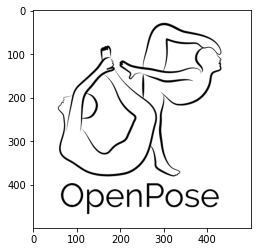

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
type(img)

PIL.PngImagePlugin.PngImageFile

In [ ]:
img_0 = img.copy()

In [ ]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(100)
        ])

In [ ]:
img_crop = data_transforms(img_0)

In [ ]:
type(img_crop)

PIL.Image.Image

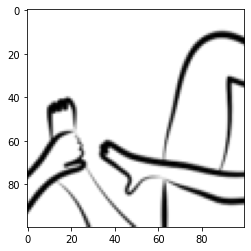

In [ ]:
plt.imshow(img_crop)
plt.show()

In [ ]:
img_1 = img.copy()

In [ ]:
transformations = transforms.Compose([
#     transforms.Resize((255,255)),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(0.0,0.1,0.1)
#     transforms.CenterCrop(224)
    
])

In [ ]:
img_center_crop = transformations(img_1)

TypeError: ignored

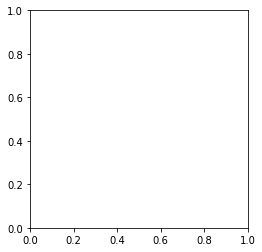

In [ ]:
plt.imshow(img_center_crop)
plt.show()

### Тензоры

Те́нзор (от лат. tensus, «напряжённый») — объект линейной алгебры, линейно преобразующий элементы одного линейного пространства в элементы другого.

https://ftfsite.ru/wp-content/files/tensor_dla_chainikov_2.1.pdf